# Real-Time Face Mask Detection — CNN Case Study

Training a CNN to detect whether a person is wearing a mask, and then using OpenCV for **real-time webcam detection**.

## 1) Dataset Preparation

We will use the **Face Mask Detection Dataset** from Kaggle or GitHub.

**Kaggle dataset:** https://www.kaggle.com/datasets/omkargurav/face-mask-dataset

Expected folder structure:
```
Face Mask Dataset/
  Train/
    with_mask/
    without_mask/
  Test/
    with_mask/
    without_mask/
  Validation/
    with_mask/
    without_mask/
```

In [1]:
!curl -L -o face-mask-dataset.zip\
  https://www.kaggle.com/api/v1/datasets/download/omkargurav/face-mask-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  163M  100  163M    0     0  90.3M      0  0:00:01  0:00:01 --:--:--  144M


In [2]:
!unzip face-mask-dataset.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/with_mask/with_mask_3297.jpg  
  inflating: /content/data/with_mask/with_mask_3298.jpg  
  inflating: /content/data/with_mask/with_mask_3299.jpg  
  inflating: /content/data/with_mask/with_mask_33.jpg  
  inflating: /content/data/with_mask/with_mask_330.jpg  
  inflating: /content/data/with_mask/with_mask_3300.jpg  
  inflating: /content/data/with_mask/with_mask_3301.jpg  
  inflating: /content/data/with_mask/with_mask_3302.jpg  
  inflating: /content/data/with_mask/with_mask_3303.jpg  
  inflating: /content/data/with_mask/with_mask_3304.jpg  
  inflating: /content/data/with_mask/with_mask_3305.jpg  
  inflating: /content/data/with_mask/with_mask_3306.jpg  
  inflating: /content/data/with_mask/with_mask_3307.jpg  
  inflating: /content/data/with_mask/with_mask_3308.jpg  
  inflating: /content/data/with_mask/with_mask_3309.jpg  
  inflating: /content/data/with_mask/with_mask_331.jpg  
  inflating: /content/dat

## 2) Imports and Setup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.metrics import classification_report, confusion_matrix
import cv2


## 3) Data Generators

In [4]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

In [5]:
base_dir = '/content/data'

In [10]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [11]:
train_gen = datagen.flow_from_directory(
    '/content/data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

Found 6043 images belonging to 2 classes.


In [12]:
val_gen = datagen.flow_from_directory(
    '/content/data',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)

Found 1510 images belonging to 2 classes.


## 4) Build CNN Model

In [13]:
def build_mask_cnn(input_shape=(128,128,3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [14]:
model = build_mask_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Compile and Train

In [15]:
model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

EPOCHS = 5  # quick demo
history = model.fit(train_gen, validation_data=val_gen, epochs=EPOCHS)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 54/189 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - accuracy: 0.6133 - loss: 0.6527

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


189/189 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7318 - loss: 0.5240 - val_accuracy: 0.9192 - val_loss: 0.2209
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.9023 - loss: 0.2543 - val_accuracy: 0.9179 - val_loss: 0.2162
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.9108 - loss: 0.2268 - val_accuracy: 0.9212 - val_loss: 0.2016
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9281 - loss: 0.1884 - val_accuracy: 0.9252 - val_loss: 0.1963
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.9365 - loss: 0.1802 - val_accuracy: 0.9285 - val_loss: 0.1852


### Training Curves

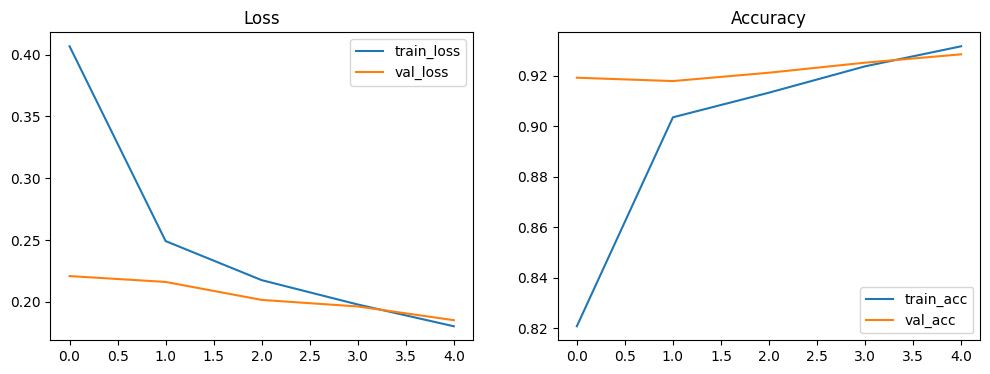

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy')
plt.show()


## 6) Evaluation on Test Set

In [17]:
val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = val_gen.classes

48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step


In [18]:
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))
cm = confusion_matrix(y_true, y_pred)
print(cm)

              precision    recall  f1-score   support

   with_mask       0.50      0.52      0.51       745
without_mask       0.52      0.50      0.51       765

    accuracy                           0.51      1510
   macro avg       0.51      0.51      0.51      1510
weighted avg       0.51      0.51      0.51      1510

[[389 356]
 [386 379]]


## 7) Save Model

In [21]:
model.save('/content/mask_detector_model.h5')
print("Model saved as mask_detector_model.h5")


Model saved as mask_detector_model.h5


## Conclusion
- This CNN model detects face masks with high accuracy.
- Real-time detection can be deployed in surveillance systems.
- Further improvements: use transfer learning (e.g., MobileNetV2) for better speed and accuracy.